<a href="https://colab.research.google.com/github/vjcitn/terravar/blob/master/demo_gs_zip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a tailored R package set in colab

Vince Carey, BJ Stubbs

In this example, we retrieve a collection of compiled packages from a public google bucket, add to .libPaths, and run code to illustrate population stratification in 1000 genomes data.

## Retrieve packages

The popstr_pkgs_colab.zip file was created by zipping the folders corresponding to packages required for
these computations.  It has to be made in colab.

In [0]:
system("gcloud config set account stvjc@channing.harvard.edu", intern=TRUE)

character(0)

In [0]:
system("gcloud config set project landmarkanvil", intern=TRUE)

In [0]:
system("gsutil cp gs://bioc_pkgs_aug_2019/popstr_pkgs_colab.zip .", intern=TRUE)

character(0)

In [0]:
system("mkdir popstrat_pkgs")
setwd("popstrat_pkgs")
system("unzip ../popstr_pkgs_colab.zip")
setwd("..")

In [0]:
.libPaths(c("popstrat_pkgs", .libPaths()))

## Use the code

### Attach key packages

In [0]:
BiocManager::install("bit64")

Bioconductor version 3.9 (BiocManager 1.30.4), R 3.6.2 (2019-12-12)

Installing package(s) 'bit64'

also installing the dependency ‘bit’


Update old packages: 'BiocManager', 'biomaRt', 'ensembldb', 'GenomicRanges',
  'httpuv', 'IRanges', 'lambda.r', 'later', 'ldblock', 'matrixStats',
  'promises', 'rapiclient', 'RCurl', 'reticulate', 'Rsamtools', 'RSQLite',
  'rtracklayer', 'S4Vectors', 'shiny', 'survival', 'XML', 'askpass',
  'assertthat', 'base64enc', 'BH', 'brew', 'broom', 'cellranger', 'cli',
  'clisymbols', 'colorspace', 'commonmark', 'crayon', 'crosstalk', 'curl',
  'DBI', 'desc', 'DT', 'fansi', 'farver', 'forcats', 'generics', 'gh', 'glue',
  'gtable', 'highr', 'hms', 'ini', 'jsonlite', 'knitr', 'labeling', 'lazyeval',
  'lubridate', 'magrittr', 'memoise', 'mime', 'munsell', 'pillar', 'pkgload',
  'plogr', 'praise', 'prettyunits', 'ps', 'RColorBrewer', 'readr', 'readxl',
  'rematch', 'reshape2', 'rex', 'rprojroot', 'rstudioapi', 'sessioninfo',
  'sourcetools', 'stringi', 'strin

In [0]:
suppressPackageStartupMessages({
    library(snpStats)
    library(terravar)
    library(BiocSklearn)
    library(ldblock)
    library(GenomicFiles)
    library(VariantAnnotation)
    library(ggplot2)
})

###  Read a slice of VCF corresponding to a region of chr17
EBI has updated 1000 genomes calls. We will interrogate a tabix-indexed VCF for chr17 via HTTP. An object that organizes multiple chromosomes is created using stack1kg from the ldblock package.

In [0]:
st = stack1kg("17")

We use a ScanVcfParam to define a slice of genome.  Reading can take a minute or so.

In [0]:
sp = ScanVcfParam(geno="GT", 
    which=GRanges("17", IRanges(32e6,33.75e6)))
myread = readVcfStack(st, param=sp)

readVcfStack produces a CollapsedVCF instance in memory. See the documentation for the VariantAnnotation package for details on this data structure.

In [0]:
myread

class: CollapsedVCF 
dim: 49194 2548 
rowRanges(vcf):
  GRanges with 5 metadata columns: paramRangeID, REF, ALT, QUAL, FILTER
info(vcf):
  DataFrame with 12 columns: AF, AC, NS, AN, EAS_AF, EUR_AF, AFR_AF, AMR_AF,...
info(header(vcf)):
             Number Type    Description                                        
   AF        A      Float   Estimated allele frequency in the range (0,1)      
   AC        A      Integer Total number of alternate alleles in called geno...
   NS        1      Integer Number of samples with data                        
   AN        1      Integer Total number of alleles in called genotypes        
   EAS_AF    A      Float   Allele frequency in the EAS populations calculat...
   EUR_AF    A      Float   Allele frequency in the EUR populations calculat...
   AFR_AF    A      Float   Allele frequency in the AFR populations calculat...
   AMR_AF    A      Float   Allele frequency in the AMR populations calculat...
   SAS_AF    A      Float   Allele frequency

## Transform the VCF content to allele counts
We use tools in David Clayton’s snpStats package to achieve a compact representation of (possibly uncertain) genotype calls. This enables us to filter to SNP with MAF exceeding a given threshold, and, later, to compute a PCA.

In [0]:
library(snpStats)
mymat = genotypeToSnpMatrix(myread)
cs = col.summary(mymat[[1]])
sum(cs[,"MAF"]>.1, na.rm=TRUE)

non-single nucleotide variations are set to NA



[1] 2909

### Build a matrix of B-allele counts
We'll use SNP with MAF exceeding 10%, and build the sample x SNP matrix.

In [0]:
kpsnp = which(cs[,"MAF"]>.1)
cmat = matrix(0, nr=nrow(mymat[[1]]), nc=length(kpsnp))
for (i in seq_len(length(kpsnp))) {
  cmat[,i] = as(mymat[[1]][,kpsnp[i]], "numeric")
  }
rownames(cmat) = rownames(mymat[[1]])

### Compute principal components and plot

We use sklearn's incremental PCA, a 4x speedup relative to prcomp, but an approximate result.

In [0]:
ppp = skIncrPCA(cmat)  
pp = list()
pp$x = getTransformed(ppp)
dim(pp$x)
rownames(pp$x) = rownames(cmat)
colnames(pp$x) = paste0("PC", 1:2548)

[1] 2548 2548

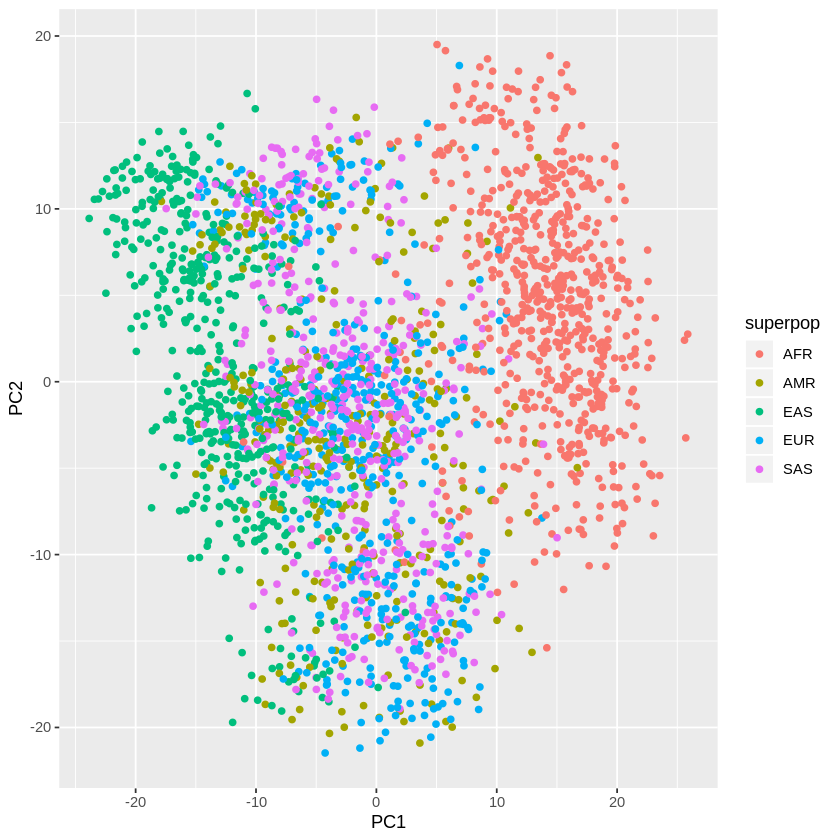

In [0]:
library(ggplot2)
library(terravar)
data("geog_1kg")
rownames(geog_1kg) = geog_1kg[,1]
newdf = data.frame(pp$x[,1:4], pop=geog_1kg[rownames(pp$x), "Population"],
    superpop = geog_1kg[rownames(pp$x), "superpop"])
ggplot(newdf, aes(x=PC1, y=PC2, colour=superpop)) + geom_point()

In [0]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.2.1                          
 [2] VariantAnnotation_1.30.1               
 [3] GenomicFiles_1.20.0                    
 [4] rtracklayer_1.44.2                     
 [5] Rsamtools_2.0.0                        
 [6] Biostrings_2.52.

In [0]:
library(BiocManager)
valid()

Warning message:
“86 packages out-of-date; 0 packages too new”



* sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BiocManager_1.30.4                     
 [2] ggplot2_3.2.1                          
 [3] VariantAnnotation_1.30.1               
 [4] GenomicFiles_1.20.0                    
 [5] rtracklayer_1.44.2                     
 [6